In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.transform import Affine

import pds4_tools

from scipy import signal
from scipy.ndimage import gaussian_filter

In [5]:
cprfile = "data2017/Clip_tessera/nedolya_cpr_norm.tif"
incifile = "data2017/Clip_tessera/nedolya_inc.tif"
ocpfile = "data2017/Clip_tessera/nedolya_ocp_filt_norm.tif"
scpfile = "data2017/Clip_tessera/nedolya_scp_filt_norm.tif"

In [6]:
def tiff2numpy(file):
    inds = rasterio.open(file)
    data = inds.read(1)
    return data

In [14]:
cpr = tiff2numpy(cprfile).ravel()
inci = tiff2numpy(incifile).ravel()

cpr[np.where(np.abs(cpr)>10)] = np.nan
inci[np.where(np.abs(cpr)>10)] = np.nan

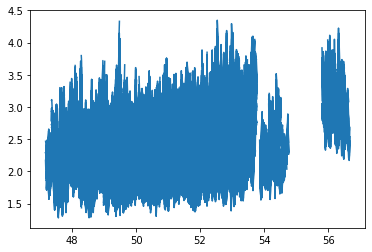

In [15]:
fig, ax = plt.subplots(1,1)
ax.plot(inci.flatten(), cpr.flatten())
plt.show()